In [1]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Seed-> Sim (Fig 2)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 

"""

'\nPrediction file: Based on the trained neural network,see the performace on the testing set\nMapping Seed-> Sim (Fig 2)\n\nGeneral workflow\nLoad test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> \nDecode into higher dimensional representation using SD VAE-> Display \n\n'

In [2]:
# import libraries 

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time


from models.vae import decode_img
from models.dilResNet import PDEArenaDilatedResNet



from utils.config import SIMULATION_TEST_INPUT_FOLDER_2,SIMULATION_TEST_OUTPUT_FOLDER_2
from utils.config import MODEL_DILRESNET_FIG2 

from utils.display import display_predicted_images
from utils.preprocess import preprocess_simulation_input_data,preprocess_simulation_output_data


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-11-18 13:47:20,779] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# prediction from testing dataset

'''
Loading test data for model testing

'''

path_output_2=SIMULATION_TEST_OUTPUT_FOLDER_2
path_input_2=SIMULATION_TEST_INPUT_FOLDER_2




## add some of the images from the main dataset that hasn't been used to train the network 

start_index = 70000  
end_index = 70100 
output_data_2=preprocess_simulation_output_data(path_output_2, start_index, end_index)

# input data

start_index = 70000  
end_index = 70100
input_data_2=preprocess_simulation_input_data(path_input_2, start_index, end_index)

X=output_data_2
y=input_data_2


# size of input data is 32x32 and output data is 256x256
X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,32,32)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)


In [4]:
'''
Defining dilResNet model for loading model weights
'''

model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


Prediction time: 11.6277 seconds
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


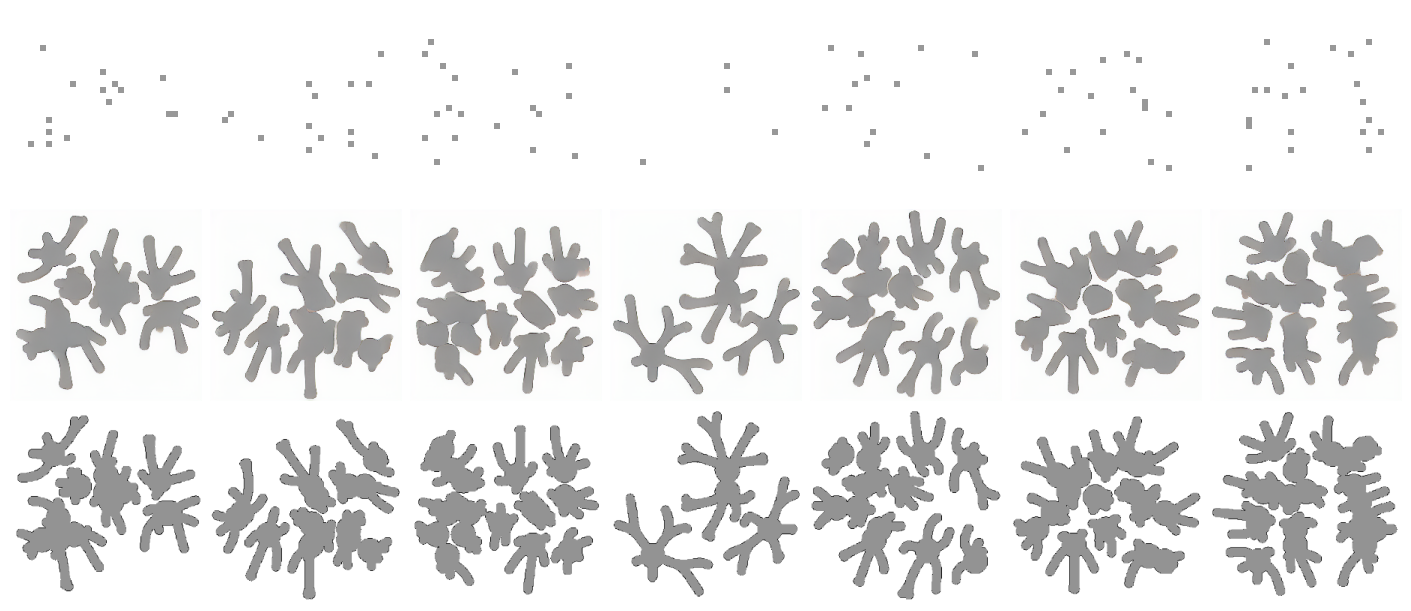

In [5]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns 

'''

device=torch.device("cpu")

# load trained model weights
model.load_state_dict(torch.load(MODEL_DILRESNET_FIG2))
model.to(device)

model.eval()

start_time=time.perf_counter()
batch_size=64



with torch.no_grad():
    for i in range(0, len(y3), batch_size):
        batch = y3[i:i+batch_size].to(device) 
        predicted_latents=model(batch)  #y3 is the input seed with 3 channels for the UNET 

end_time=time.perf_counter()

print(f"Prediction time: {end_time - start_time:.4f} seconds")


with torch.no_grad():
    predicted_latents=model(y3[:,:,:,:].to(device))  #y3 is the input seed with 3 channels for the UNET 


predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns


# move to cpu for benchmarking

pred_images=decode_img(predicted_latents_rescaled)


selected_indices=[14,18,9,10,4,5,2] 
# Display samples from train dataset
order=[0,2,1]


display_predicted_images(y3[selected_indices,:,:,:],X[selected_indices,:,:,:], pred_images[selected_indices,:,:,:] ,len(selected_indices), order=order)   #

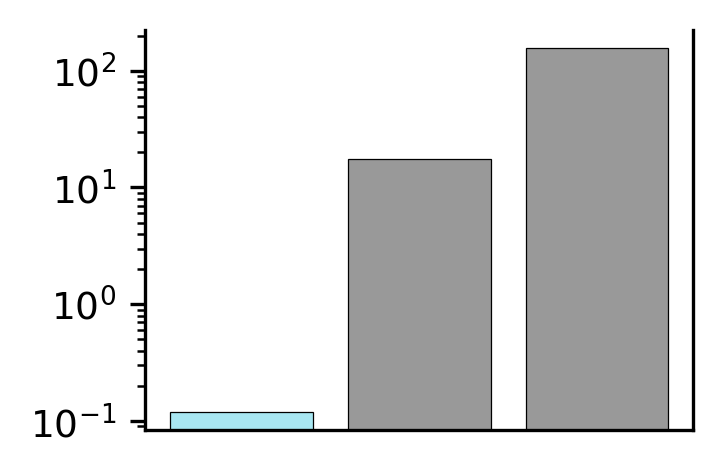

In [7]:
# plot the benchmarking graph 

# for 100 images, the time for prediction using GPU is 0.15s, and using CPU is 8.0s->100 times slower

# Prediction with trained ML model, using CPU + generation of MATLAB scripts 

# Parallel total time: 29 min for 100 images. (times from email slurm jobs) 
# Serial total time: 04 hours, 22 min for 100 images. (times from email slurm jobs)

#for A4 size
height_figure= 4.404 /2.54 # in inches
width_figure= 5.985 /2.54 # in inches
fig,ax=plt.subplots(1,1,figsize=(width_figure,height_figure),dpi=300) # A4 size in inches

times=[12/100,29*60/100,(4*60+22)*60/100] # in seconds
labels=['ML surrogate','PDE Simulation(Parallel computing)','PDE simulation']


bar_colors=['#a6e7f2fa','#707070b5','#707070b5']
ax.bar(labels,times,color=bar_colors,edgecolor='black',linewidth=0.3)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=9)
# hide the x ticks
ax.set_xticks([])
# remove the top border
ax.spines['top'].set_visible(False)

# ax.tick_params(axis='x', labelsize=15)
# ax.set_ylabel('Time (seconds)',fontsize=20)
plt.show()